In [19]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import colors
from matplotlib import rc

from scipy.integrate import solve_ivp # builtin integrator

#rc('font',**{'family':'serif','serif':['Palatino']})
#rc('text', usetex=True)

## Setup

The initial value problem (general first order) is:
$$
\begin{gather*}
\frac{\mathrm{d}y}{\mathrm{d}t} = f(t,y) & y(t_{0}) = y_{0}
\end{gather*}
$$

With the objective being to approximate $y(t)$ given these constraints (initial condition and derivative).


So let's define a set of constraints to work validate against:
$$
\begin{gather*}
f(t, y) - y = -\frac{1}{2}e^{\frac{t}{2}}\sin(5t) + 5e^{\frac{t}{2}}\cos(5t) & y(0) = 0
\end{gather*}
$$
Meaning we're given the derivative $\frac{\mathrm{d}y}{\mathrm{d}t} = f(t,y) =  -\frac{1}{2}e^{\frac{t}{2}}\sin(5t) + 5e^{\frac{t}{2}}\cos(5t) + y$.

The solution to this linear first order differential equation is:
$$
\begin{align*}
y(t) &= e^{\frac{t}{2}}\sin(5t)
\end{align*}
$$

In [9]:
# declare the constraints
y0 = 0

def f(t, y):
    """
    the derivative of the function we seek to approximate
    
    args:
        :t (float) - the timestep of interest
        :y (float) - the y value 
        
    returns:
        :(float) - dy/dt (t,y)
    """
    
    return -(1/2)*np.exp(t/2)*np.sin(5*t) + 5*np.exp(t/2)*np.cos(5*t) + y

def y(t):
    """
    the actual function we'd like to approximate
    
    args:
        :t (float) - timestep
    """
    
    return np.exp(t/2)*np.sin(5*t)

## Euler's Method
This method, also known is technically the Runge-Kutta first order solver. The equation for it is given by:
$$
\begin{align*}
y_{n+1} &= y_{n} + hf(t_{n}, y_{n})
\end{align*}
$$

Where $h=t_{n+1}-t_{n}$.

## Heun's Method
AKA Runge-Kutta 2nd order aka Modified Euler's method
Approximate $\int f(t,y)\mathrm{d}t = \int \frac{\mathrm{d}y}{\mathrm{d}t}\mathrm{d}t = \int \mathrm{d}y = y$ even more accurately by evaluating farther into the future:
$$
\begin{align*}
y_{h} = y_{n+1} = y_{n} + \frac{h}{2}\bigg{[}f(t_{n},y_{n}) + f(t_{n+1},\hat{y}_{n+1})\bigg{]}
\end{align*}
$$
Where $\hat{y}$ is approximated using Euler's method.

In [5]:
def Euler(yn,tn,h,dydt):
    """
    Compute the Euler's method approximation of unknown function F at position i ( F(i) )
    
    args:
        :yi (float) - the initial condition
        :t (float) - timestep of interest
        :h (float) - stepsize
        :dydt (function) - dF/dt --> should take two parametrs *(float,float) = t,yn
        
    returns:
        :(float) - the approximation
    """
    return yn + dydt(tn,yn) * h

def Heun(yn,tn,h,dydt):
    """
    Compute the Heuns's method approximation of unknown function F at position i ( F(i) )
    
    args:
        :yi (float) - the initial condition
        :t (float) - timestep of interest
        :h (float) - stepsize
        :dydt (function) - dF/dt --> should take two parameters *(float,float) = t,yn
        
    returns:
        :(float) - the approximation
    """
    
    ynp1 = Euler(yn,tn,h,dydt)
    return yn + (h/2)*(dydt(tn,yn) + dydt(tn + h, ynp1))

def approximate(y0, dydt, t, solver):
    """
    steps through an approximation of F = integral(dydt) using the solver 
    for each timestep in t
    
    args:
        :y0 (float) - initial condition F(0)
        :dydt (function) - the derivative of F
        :t (list, np.array) - the timesteps to consider
        :solver (function) - the method used to approximate F
        
    returns:
        :(np.array) - approximation of F from t0 to tn
    """
    n = len(t) # number of timesteps to approximate into the future
    h = abs(t[0] - t[1]) # assuming linearly spaced timesteps
    
    Fhat = np.zeros(n) # the list of approximations of F s.t Fhat[i] ~= F(i)
    Fhat[0] = y0
    
    for i in range(1,n,1):
        Fhat[i] = solver(Fhat[i-1],t[i-1],h,dydt)
    
    return Fhat

def rk1(y0, dydt, t):
    """
    Runge-Kutta 1st order (Euler's method)
    """
    return approximate(y0, dydt, t, Euler)

def rk2(y0, dydt, t):
    """
    Runge-Kutta 2nd order (Heun's Method)
    """
    return approximate(y0, dydt, t, Heun)

120


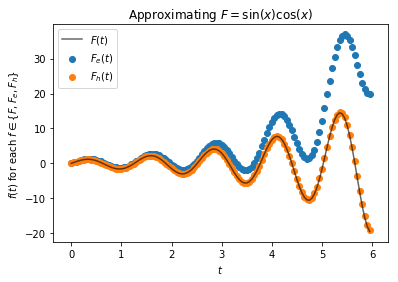

In [6]:
tn = 6
h = 0.05
t = np.arange(0,tn,h) # [0,2pi] in steps of H
print(len(t))
plt.scatter(t,rk1(y0=y0,dydt=f,t=t),label="$F_{e}(t)$")
plt.scatter(t,rk2(y0=y0,dydt=f,t=t),label="$F_{h}(t)$")
plt.title("Approximating $F = \sin(x)\cos(x)$")
plt.plot(t, y(t),alpha=0.6,label='$F(t)$',color="black")

plt.legend()
plt.xlabel("$t$")
plt.ylabel("$f(t)$ for each $f \in \{F, F_{e}, F_{h}\}$")
plt.show()

Testing out a python builtin integrator

In [20]:
solve_ivp?

In [21]:
t0 = 0
t_bd = tn

def f_ivp(t,y):
    """
    wrapper func for f(t,y) defined above to return proper type
    of output for solve_ivp function (accepts array-like inputs)
    """
    
    return np.array([f(t,y)])

In [39]:
solve = solve_ivp(f_ivp, (t0, tn), [y0],t_eval=t, method="RK45")
#solve.step_size = h
solve.y = np.reshape(solve.y, (solve.y.shape[1],))
solve.y.shape

(120,)

120


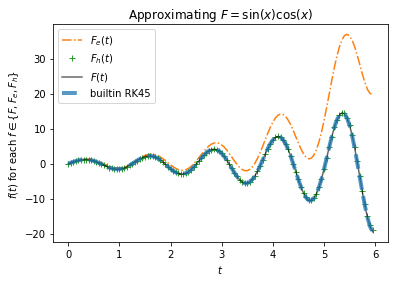

In [73]:
#plt.xlabel("$t$")
#plt.ylabel("RK45 Approximation of y(t)")
print(len(t))
plt.plot(t,rk1(y0=y0,dydt=f,t=t),label="$F_{e}(t)$",linestyle="-.",color="C1")
plt.plot(t,rk2(y0=y0,dydt=f,t=t),label="$F_{h}(t)$",linestyle="",color="C2",marker="+")
plt.title("Approximating $F = \sin(x)\cos(x)$")
plt.plot(t, y(t),alpha=0.6,label='$F(t)$',color="black")
plt.plot(solve.t, solve.y,label="builtin RK45",linestyle="--",markersize=1,linewidth=4,color="C0",alpha=0.75)

plt.legend()
plt.xlabel("$t$")
plt.ylabel("$f(t)$ for each $f \in \{F, F_{e}, F_{h}\}$")
plt.show()
plt.show()